# Table of contents 
- [Setup](#setup)
    - [Purpose](#purpose)
    - [Libraries](#libraries) 
- [](#)
- [](#)
- [References](#references)


<a name='setup'></a>
# 0. Setup 

This notebook contains the code to investigate the extent of dataset reuse; specifically the reuse of the datasets used in the articles published in NeuroImage in 2022. 

<a name='purpose'></a>
## 0.1. Purpose 

The purpose of this notebook is to investigate how many other articles across articles available in OpenAlex use the same datasets as those used by the researchers who published their work in NeuroImage in 2022. 
This notebook draws on the work by Theó Sourget (2023a, 2023b), who similarly investigated the usage of a select couple of datasets. 

<a name='libraries'></a>
## 0.2. Libraries 

In [453]:
import pandas as pd 
import numpy as np 
import requests
import csv
import re
import json
import os
import ast 

# Matplotlib for visualisations (Hunter 2007)
import matplotlib.pyplot as plt

In [ ]:
# Reuse of the links: how many use each of the links in urls = pd.read_csv('../Data/material_URLs.csv')

In [424]:
# The filtered_articles_all_urls.csv have links like creativecommons.org removed 
articles_df = pd.read_csv('../Data/articles_filtered_urls.csv')
articles_dois = pd.read_csv('../Data/ElsevierAPI/articles_doi.csv')
material_urls = pd.read_csv('../Data/material_URLs.csv')
classified_df = pd.read_csv('../Data/classified_data.csv')

In [425]:
articles_dois = articles_dois.rename(columns={"DOIs": "DOI"})
articles_dois['DOI'] = articles_dois['DOI'].str.replace('.pdf', '', regex=False)

In [426]:
len(material_urls)

305

# 1. NeuroImage 

searching: excluding what's in front of the link (i.e., www, https://), but being specific about the fact that it has to end the same way 

NeuroImage 
-  The most used material URL among NeuroImage
    - Is this material URL a specific dataset?
    - If it is a specific dataset - do some of the other URLs also contain the same data? (look through the validated URLs) 

General reuse 

## 1.1. Articles containing material URLs

- Find out how many articles contain dataset URLs from material_urls
    - overview of articles in total that link to a dataset
    - overview of articles that link to one or more datasets 

In [427]:
material_counts = classified_df[classified_df['Material'] == 1].groupby('DOI').size().reset_index(name='material_count')
material_counts['DOI'] = material_counts['DOI'].str.replace('/', '.')

all_dois = articles_dois['DOI'].tolist()

missing_dois = set(all_dois) - set(material_counts['DOI'])
missing_counts = pd.DataFrame({'DOI': list(missing_dois), 'material_count': 0})
material_counts = pd.concat([material_counts, missing_counts], ignore_index=True)

# Create a column indicating if the article has material URLs
material_counts['Has_Material_URL'] = material_counts['material_count'] > 0

total_articles = len(articles_dois)
articles_without_material = total_articles - len(material_counts[material_counts['Has_Material_URL']])

In [428]:
material_counts

,DOI,material_count,Has_Material_URL
0,10.1016.j.neuroimage.2021.118698,1,True
1,10.1016.j.neuroimage.2021.118718,1,True
2,10.1016.j.neuroimage.2021.118739,3,True
3,10.1016.j.neuroimage.2021.118748,1,True
4,10.1016.j.neuroimage.2021.118751,1,True
...,...,...,...
810,10.1016.j.neuroimage.2022.119763,0,False
811,10.1016.j.neuroimage.2022.119525,0,False
812,10.1016.j.neuroimage.2022.119475,0,False
813,10.1016.j.neuroimage.2022.119077,0,False


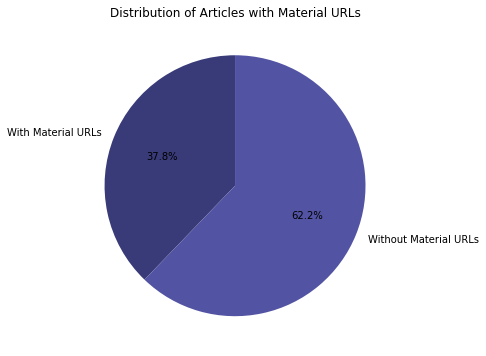

In [429]:
# Create a pie chart showing the distribution of articles with and without material URLs
plt.figure(figsize=(10, 6))
plt.pie([len(material_counts[material_counts['Has_Material_URL']]), articles_without_material], labels=['With Material URLs', 'Without Material URLs'],
        autopct='%1.1f%%', startangle=90, colors=plt.cm.tab20b.colors)
plt.title('Distribution of Articles with Material URLs')
plt.savefig('../Results/graphics/NeuroImage_ArticlesWithMaterialURLs.png')
plt.show()

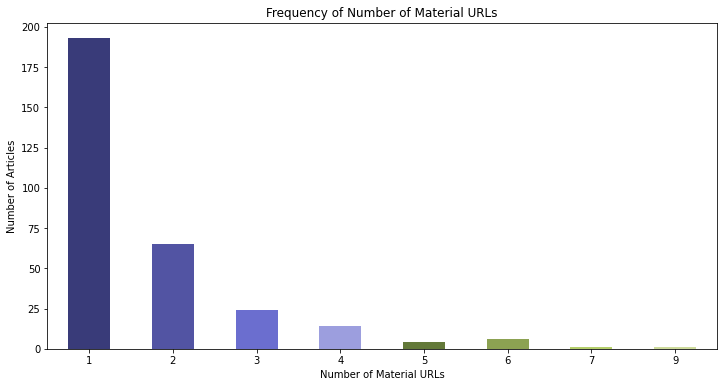

In [430]:
# Create a bar plot showing the frequency of articles with material URLs
plt.figure(figsize=(12, 6))
material_counts[material_counts['Has_Material_URL']]['material_count'].value_counts().sort_index().plot(kind='bar', color=plt.cm.tab20b.colors)
plt.title('Frequency of Number of Material URLs')
plt.xlabel('Number of Material URLs')
plt.ylabel('Number of Articles')
plt.xticks(rotation=0)
plt.savefig('../Results/graphics/NeuroImage_NumberOfMaterialURLs.png')
plt.show()

## 1.2. URL link mentions 

I clean the URLs in articles_df['URL'] the same way I cleaned the URL in 'Code/classifier_SciBERT.ipynb'

-  The most used material URLs among NeuroImage
    - Is this material URL a specific dataset?
    - If it is a specific dataset - do some of the other URLs also contain the same data? (look through the validated URLs) 

In [431]:
def clean_urls(urls):
    """Remove http://, https://, https://www., www. and trailing / or /). 
    Additionally, I will remove the words and characters found in 'Code/classifier_SciBERT.ipynb' and highlighted in 'Data/'URLs_validated_comments.csv'. 
    This includes the following trailing strings and characters: 
        - apply, the, and, data, supplementary, credit, 3 
        - *, ), (
        	- (under, (dataset, (Grootswagers
    """
    # Remove http://, https://, https://www., www. and trailing / or /)
    cleaned_urls = urls.str.replace(r'^https?://(?:www\.)?|www\.|/$|/\)$', '', regex=True, flags=re.IGNORECASE)

    # Lowercase the URLs
    cleaned_urls = cleaned_urls.str.lower()
    
    # Remove specific words and characters that made more than one URL invalid in 'classifier_SciBERT.ipynb'
    words_to_remove = ['the', 'and', ')', '(']
    for word in words_to_remove:
        cleaned_urls = cleaned_urls.str.replace(r'/{}\b$'.format(re.escape(word)), '', regex=True, flags=re.IGNORECASE)

    return cleaned_urls

A couple of the URLs were manually edited upon manually validating them ('Code/classifier_SciBERT.ipynb', section 3.1. Validate URLs). I will change the URLs that were replaced. 

In [432]:
# Clean the URLs 
articles_df['Clean URL'] = clean_urls(articles_df['URL'])

In [433]:
changed_urls = pd.read_csv('../Data/URLs_validated_comments.csv', delimiter=';', usecols=range(5)) 
changed_urls = changed_urls[changed_urls['Link that works'].notna()]

In [434]:
# Dictionary mapping original URLs to replacement values
url_replacement_dict = dict(zip(changed_urls['URL'], changed_urls['Link that works']))

# Replace URLs in articles_df['URL'] using the dictionary
articles_df['Clean URL'] = articles_df['Clean URL'].replace(url_replacement_dict)

# Clean the URLs again
articles_df['Clean URL'] = clean_urls(articles_df['Clean URL'])

In [435]:
# Make sure each clean URL only appears once per DOI
articles_df_unique = articles_df.drop_duplicates(subset=['Clean URL', 'DOI'])

In [436]:
print(len(articles_df))
print(len(articles_df_unique))

3002
2937


In [437]:
# Count the occurrences of each cleaned URL in articles_df
url_counts = articles_df_unique['Clean URL'].value_counts() 

# Check how many times each URL from material_urls appears in articles_df 
material_urls['Count in articles'] = material_urls['Material_URL'].map(url_counts)

# Sort material_urls by 'Count_in_Articles' in descending order
material_urls_sorted = material_urls.sort_values(by='Count in articles', ascending=False)

In [459]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [439]:
material_urls_sorted

,Material_URL,Count in articles
292,surfer.nmr.mgh.harvard.edu,48
115,humanconnectome.org,28
51,db.humanconnectome.org,22
36,clinicaltrials.gov,20
1,adni.loni.usc.edu,17
163,neurosynth.org,12
121,humanconnectome.org/study/hcp-young-adult,12
124,humanconnectome.org/study/hcp-young-adult/document/1200-subjects-data-release,10
304,ﬁl.ion.ucl.ac.uk,9
0,abcdstudy.org,8


In [440]:
material_urls_sorted[material_urls_sorted['Count in articles'].isna()]

,Material_URL,Count in articles


In [441]:
# Assuming 'Count in articles' is the column in material_urls_sorted representing the count
count_statistics = material_urls_sorted['Count in articles'].describe()

# Print the summary statistics
print(round(count_statistics, 1))

count    305.0
mean       1.9
std        3.8
min        1.0
25%        1.0
50%        1.0
75%        1.0
max       48.0
Name: Count in articles, dtype: float64


In [442]:
# Get the top fifteen most mentioned URLs
top_fifteen_urls = material_urls_sorted.head(15)

In [443]:
top_fifteen_urls

,Material_URL,Count in articles
292,surfer.nmr.mgh.harvard.edu,48
115,humanconnectome.org,28
51,db.humanconnectome.org,22
36,clinicaltrials.gov,20
1,adni.loni.usc.edu,17
163,neurosynth.org,12
121,humanconnectome.org/study/hcp-young-adult,12
124,humanconnectome.org/study/hcp-young-adult/document/1200-subjects-data-release,10
304,ﬁl.ion.ucl.ac.uk,9
0,abcdstudy.org,8


- surfer.nmr.mgh.harvard.edu: This is actually not a dataset but an open-source toolkit for processing, analyzing, and visualizing brain images. This URL was falsely classified as Material. 
- humanconnectome.org: This website contains multiple datasets, so it's possible that the links were cut short or that the specific dataset was mentioned in the text.
- db.humanconnectome.org: This website is a data management platform where users can access the datasets from the Human Connectome Project, i.e., the same datasets as the link before. You need a login.
- clinicaltrials.gov: The website contains multiple datasets, so it's possible that the links were cut short or that the specific dataset or search conditions were mentioned in the text. 
- adni.loni.usc.edu: This website contains multiple datasets, including the ADNI data, DoD-ADNI data, and the AIBL data. 
- neurosynth.org: This website is a database containing 14371 studies and maps for over 150,000 brain locations. 
- humanconnectome.org/study/hcp-young-adult: This is a dataset; there are two available releases following this link. 
- humanconnectome.org/study/hcp-young-adult/document/1200-subjects-data-release: This is the documentation of a specific dataset on how to use it. 
- fil.ion.ucl.ac.uk: This is the website for a laboratory associated with an institution of neurology - they offer access to a couple of different datasets on a subsection on their website (https://www.fil.ion.ucl.ac.uk/spm/data/). As this website contains multiple datasets, it's possible that the links were cut short or that the specific dataset was mentioned in the text. 
- abcdstudy.org: This is the website for a research consortium involving 21 research sites across the US. They offer access to the most recent version of their dataset (they link it on a subsite, https://abcdstudy.org/scientists/data-sharing/, that points to a website external of abcdstudy.org, https://nda.nih.gov/study.html?id=2147). The exact dataset is hosted on another website and multiple versions have been published, so it's possible that this dataset was referred to using other links. 
- brain-development.org/ixi-dataset: This website contains 600 MR images using different image acquisition protocols from normal, healthy subjects collected at three hospitals. 
- coins.trendscenter.org: This website is a data management system that provides an interface for data collection, managing, and sharing. The website contains a 'Data Exchange', where datasets like The Autism Brain Imaging Data Exchange (ABIDE), The Center for Biomedical Research Excellence (COBRE), Consortium for Reliability and Reproducibility (CoRR), The Enhanced NKI Rockland Sample, and The MIND Clinical Imaging Consortium have been shared. As this website contains multiple datasets, it's possible that the links were cut short or that the specific dataset were mentioned in the text. 
- itksnap.org/pmwiki/pmwiki.php: This is actually not a dataset but an open-source software application to segment structures in 3D and 3D biomedical images. This URL was falsely classified as Material. 
- openneuro.org: This website contains multiple datasets, so it's possible that the links were cut short or that the specific dataset was mentioned in the text.
- human.brain-map.org: This website contains multiple datasets, including microarray datasets of six brains, RNA-sequencing datasets, and archived microarray datasets. It's possible that the links were cut short or that the specific dataset was mentioned in the text.  

Investigate the sentences containing the url 'humanconnectome.org': 

In [461]:
#articles_df_unique[articles_df_unique['Clean URL']=='humanconnectome.org']['Sentences']

In [462]:
# Filter rows where Clean URL is 'humanconnectome.org'
filtered_df = articles_df_unique[articles_df_unique['Clean URL'] == 'humanconnectome.org']

# Create an empty list to store DataFrames
dfs = []

# Iterate through rows of the filtered DataFrame
for index, row in filtered_df.iterrows():
    doi = row['DOI']
    sentences_str = row['Sentences']
    
    # Safely evaluate the string as a Python literal (list)
    try:
        sentences_list = ast.literal_eval(sentences_str)
    except (SyntaxError, ValueError):
        # Handle the case where the string is not a valid Python literal
        sentences_list = []
    
    # Create a DataFrame for each sentence
    for sentence in sentences_list:
        article_df = pd.DataFrame({"Sentence containing the URL 'humanconnectome.org'": [sentence]}) # to get the DOI: 'DOI': [doi], 
        
        # Append the DataFrame to the list
        dfs.append(article_df)

# Concatenate all DataFrames into the result DataFrame
humanconnectome_sentences = pd.concat(dfs, ignore_index=True)

In [463]:
humanconnectome_sentences

,Sentence containing the URL 'humanconnectome.org'
0,Data and code availability All data used in this project is from the Human Connec-tome Project (HCP) (www.humanconnectome.org).
1,This data is publicly available to researchers who agree to the data use terms (www.humanconnectome.org/study/hcp-young-adult/data-use-terms).
2,humanconnectome.org/and https://www.developingconnectome.
3,humanconnectome.org/The tool we used for analyzing the data can be downloaded from: rsHRF: https://www.nitrc.org/projects/rshrf PhysIO Toolbox: https://www.nitrc.org/projects/physio/Circos table viewer: http://mkweb.bcgsc.ca/tableviewer/visualize/3.
4,Data and Code Availability Statement The data used in the manuscript are from the human con-nectome project (HCP; www.humanconnectome.org).
5,Data and code availability All imaging data used in this study was sourced from the Human Connectome Project (HCP) (www.humanconnectome.org).
6,A complete description of the acquisition and pre-processing details may be found at the HCP website https://www.humanconnectome.org/.
7,Data and code availability statement MRI data included in our manuscript can be accessed from https://www.humanconnectome.org.
8,"humanconnectome.org/) (Van Essen et al., 2013)."
9,"Participants 100 unrelated participants (50 females, average age = 29) were randomly selected from a dataset used in a prior study (Steele and Chakravarty, 2018) which used structural imaging data from the Human Connectome Project open-access dataset (www.humanconnectome.org) (Glasser et al., 2016 ; Steele and Chakravarty, 2018 ; Van Essen et al., 2012)."


Very few of the sentences [8/68] mention which specific HCP dataset they used. Of the mentions, most use the Healthy Adult Connectomes. 
- humanconnectome.org) from the Washington University-University of Minnesota (WUMinn) consortium, including 484 healthy participants from the Q4 release (500 subject; Nov 25, 2014; 272 females, 212 males; age = 29.15 ± 3.47).
- In the present study, we utilized a publicly available dataset, provided by the Human Connectome Project (HCP; http://www.humanconnectome.org) from the Washington University-University of Minnesota (WU-Minn) consortium, including 484 healthy participants from the Q4 release (500 subject; Nov 25, 2014).
- Primary dataset (HCP) Structural, diﬀusion and resting-state functional MRI data of 210 healthy subjects (males = 92, females = 118, age range 22-36 years) were retrieved from the HCP repository (https://humanconnectome.org).
- We obtained behavioral and neuroimaging data of 495 ran-domly selected subjects from the Human Connectome Project (HCP; www.humanconnectome.org), an open-access database aimed at col-lecting healthy participant data from over 1200 people. 
- Behavioral and neuroimaging data for this manuscript was obtained from the Human Connectome Project (HCP; www.humanconnectome.org), an open-access database aimed at collecting healthy participant data from over 1200 people.
- The signal time course was originally from the WU-Minn HCP young healthy adults (ages 22–35) S1200 release data (https://www.humanconnectome.org/study/hcp-young-adult).
- The healthy subjects’ data used in this study are openly available at https://www.humanconnectome.org/.
- For application to real-world data, we obtained resting-state fMRI data from the HCP1200 release from the Human Connectome Project (Essen et al., 2013) (https://www.humanconnectome.org).

There are a couple of sentences [4/68] that should not have been included for this URL: 
- [False hit for humanconnectome.org] This data is publicly available to researchers who agree to the data use terms (www.humanconnectome.org/study/hcp-young-adult/data-use-terms).
- [False hit for humanconnectome.org] Further details of the 7T rs-fMRI acquisition protocols are given in the HCP reference manual (https://humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).
- [False hit for humanconnectome.org] To this purpose, we employed the Con-nectome Workbench software (version 1.2.3; retrieved November 30, 2020 from https://www.humanconnectome.org/software/connectome-workbench ; Marcus et al., 2011).
- [False hit for humanconnectome.org] Both preprocessed and unpreprocessed neonatal and adult data can be freely accessed via registration to the Developing Human Connec-tome Project (dHCP); http://www.developingconnectome.org/project/and Human Connectome Project (HCP) Young Adult Database (https://www.humanconnectome.org/study/hcp-young-adult).

In [512]:
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')

---

In [ ]:
# Case exploration: how many places are HCP datasets hosted? Or maybe another dataset

Some of the URLs take you to the same dataset, e.g., *adni.loni.usc.edu* and *adni.loni.usc.edu/* so I will merge the URLs that this applies to. However, some of the URLs share a root, but shows you different datasets, e.g., all *github.com* and *openneuro.org* links.

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

In [ ]:
urls

In [ ]:
def find_root_and_derivatives(urls):
    """ 
    This function performs some initial cleaning of the URLs, removing the beginning (https:// or wwww) and puts all text into lowercase. 
    Parameters: 
    :param urls(list): Sorted list of unique URLs from a dataframe
    """    
    # Remove "https://", "http://", and "www." from the URLs
    clean_urls = [url.replace("https://", "").replace("http://", "").replace("www.", "").lower() for url in urls]
    
    url_dict = {}
    for url in clean_urls:
        root = url.split('/')[0]
        # root = '/'.join(url.split('/'))
        if root in url_dict:
            url_dict[root].append(url)
        else:
            url_dict[root] = [url]

    grouped_df = pd.DataFrame(url_dict.items(), columns=['Root', 'Derivatives']).sort_values('Root', ascending=True)

    return grouped_df

In [ ]:
test = find_root_and_derivatives(urls['Material_URL'])

In [ ]:
test

Investigating the 315 unique and valid URLs, there are 137 root websites, some leading to the same dataset, and others to different datasets. 
- IDA (Image & Data Analysis) features 25 studies, including ADNI, AIBL, and a HCP project as well as others (at another place on their website, they say they feature 151 studies)
- db.hummanconnectome.org (ConnectomeDB) gives people access to the Human Connectome Project (HCP), both lifespan and hcp-aging
- fcon_1000.projects.nitrc.org links to 1000 Functional Connectomes Project, INDI-prospective, INDI-retrospective, and Preprocessed Connectome Project
- HCP is actually Human Connectome Projects, and there are 20 connectome studies supported on humanconnectome.org (they call themselves Connectome Coordination Facility (CCF)), leading to e.gg., HCP young adult, aging, development, Amish, epilepsy, and other connectomes.
- nda.nih.gov features different datasets, including a couple of HCPs 
- datalad, github, openneuro, openfmri, osf, and zenodo link to numerous different datasets 

In [ ]:
pd.reset_option('display.max_rows')
pd.reset_option('max_colwidth')

# 2. OpenAlex reuse

You can use the search query parameters to search for various search terms across titles, abstracts, and full text (if the text has the full text available). 
I need to use the fulltext.search OpenAlexAPI (Filter works). 


References: 
- OpenAlexAPI. (n.d.-a). Filter works. OpenAlex API Documentation. Retrieved September 14, 2023, from https://docs.openalex.org/api-entities/works/filter-works
- OpenAlexAPI. (n.d.). Search Works. Retrieved November 23, 2023, from https://docs.openalex.org/api-entities/works/search-works


In [ ]:
# Get a count of how many articles has fulltext on OpenAlex out of how many in total? Is that possible? 

In [505]:
sources = requests.get(f'https://api.openalex.org/works?search=https://humanconnectome.org').json()

In [506]:
sources['meta']

{'count': 229,
 'db_response_time_ms': 58,
 'page': 1,
 'per_page': 25,
 'groups_count': None}

In [508]:
len(sources['results'])

25

In [533]:
def fetch_all_results_pagination(url_list):
    """Fetch all results from OpenAlex API using pagination for multiple URL prefixes.

    Parameters:
    - url_list (list): List of URL suffixes to search for.

    Returns:
    - list of dictionaries: Each dictionary contains information about a matching article.
    """
    all_results = []

    # List of URL prefixes to search for
    url_prefixes = ['https://', 'https://www.', 'http://', 'http://www.', 'www.']

    for url_suffix in url_list:
        for prefix in url_prefixes:
            # Construct the full URL for the API request
            api_url = f'https://api.openalex.org/works?search=:*{prefix}{url_suffix}*'

            # Initialize a list to store results for each URL prefix
            url_results = []

            page = 1

            while True:
                # Make a request to the API with the current page number
                response = requests.get(api_url, params={"page": page})

                # Check if the response is successful
                if response.status_code == 200:
                    data = response.json()

                    # Extract articles from the current page and append to the list
                    articles_on_page = data.get("results", [])
                    for result in articles_on_page:
                        primary_location = result.get('primary_location', {})
                        source = primary_location.get('source', {})
                        display_name = source.get('display_name', '')
                        print('primary_location:', primary_location)
                        print('source:', source)
                        print('display_name:', display_name)

                        result_info = {
                            'id': result.get('id', ''),
                            'doi': result.get('doi', ''),
                            'title': result.get('title', ''),
                            'publication_year': result.get('publication_year', ''),
                            #'primary_location': result.get('primary_location', {}).get('source', {}).get('display_name', ''),
                            'type_crossref': result.get('type_crossref', ''),
                            'open_access': result.get('open_access', {}).get('is_oa', ''),
                            'cited_by_count': result.get('cited_by_count', ''),
                        }
                        url_results.append(result_info)

                    # Check if there are more pages to fetch
                    if len(articles_on_page) == 0 or page * data['meta']['per_page'] >= data['meta']['count']:
                        break

                    # Increment the page number for the next request
                    page += 1
                else:
                    print("Error fetching data. Status code:", response.status_code)
                    break

            # Append the results for the current URL suffix and prefix combination to the overall results
            all_results.extend(url_results)

    return all_results

In [530]:
api_url = ['humanconnectome.org']

In [531]:
#api_url = "https://api.openalex.org/works?search=https://humanconnectome.org"
all_results = pd.DataFrame(fetch_all_results_pagination(api_url))

{'meta': {'count': 229, 'db_response_time_ms': 63, 'page': 1, 'per_page': 25, 'groups_count': None}, 'results': [{'id': 'https://openalex.org/W2499800833', 'doi': 'https://doi.org/10.1038/nature18933', 'title': 'A multi-modal parcellation of human cerebral cortex', 'display_name': 'A multi-modal parcellation of human cerebral cortex', 'relevance_score': 76.289734, 'publication_year': 2016, 'publication_date': '2016-07-20', 'ids': {'openalex': 'https://openalex.org/W2499800833', 'doi': 'https://doi.org/10.1038/nature18933', 'mag': '2499800833', 'pmid': 'https://pubmed.ncbi.nlm.nih.gov/27437579', 'pmcid': 'https://www.ncbi.nlm.nih.gov/pmc/articles/4990127'}, 'language': 'en', 'primary_location': {'is_oa': False, 'landing_page_url': 'https://doi.org/10.1038/nature18933', 'pdf_url': None, 'source': {'id': 'https://openalex.org/S137773608', 'display_name': 'Nature', 'issn_l': '0028-0836', 'issn': ['1476-4687', '0028-0836'], 'is_oa': False, 'is_in_doaj': False, 'host_organization': 'https://

AttributeError: 'NoneType' object has no attribute 'get'

In [ ]:
all_results

In [522]:
url_list = material_urls['Material_URL']

In [492]:
def search_openalex_for_all_prefixes(url_list):
    """
    Search OpenAlex for articles containing URLs with different prefixes.

    Parameters:
        - url_list (list): List of URLs to search for.

    Returns:
        - list of dictionaries: Each dictionary contains information about a matching article.
    """
    api_url = "https://api.openalex.org/works?"

    # Initialize the list to store information about matching articles
    matching_articles = []

    for url in url_list:
        # List of URL prefixes to search for
        url_prefixes = ['https://', 'https://www.', 'http://', 'http://www.', 'www.']

        # Initialize a list to store results for each URL prefix
        url_results = []

        for prefix in url_prefixes:
            # Format the API query for the given URL with the current prefix
            query = f'fulltext.search:*{prefix}{url}*'

            # Make the request to OpenAlex API
            response = requests.get(api_url, params={'filter': query})

            # Check if the request was successful (status code 200)
            if response.status_code == 200:
                # Parse the JSON response
                data = response.json()

               # Iterate through the works in the response and extract information
                for work in data.get('works', []):
                    article_info = {
                        'id': work.get('id', ''),
                        'doi': work.get('doi', ''),
                        'title': work.get('title', ''),
                        'publication_year': work.get('publication_year'),
                        'primary_location': work.get('primary_location', ''),
                        'type_crossref': work.get('type_crossref', ''),
                        'open_access': work.get('open_access', ''),
                        'cited_by_count': work.get('cited_by_count', ''),
                    }

                    # Add the information to the list for the current URL prefix
                    url_results.append(article_info)
            else:
                print(f"Error in searching for URL {url} with prefix {prefix}. Status code: {response.status_code}")

        # Add the results for the current URL to the overall matching_articles list
        matching_articles.extend(url_results)

    return matching_articles

In [493]:
# Example usage:
url = "humanconnectome.org"
matching_articles = search_openalex_for_all_prefixes(url)

In [494]:
matching_articles

[]

In [488]:
matching_articles = search_openalex_for_urls(url_list)

In [489]:
# Print the results
for article_info in matching_articles:
    print(article_info)

<a name='references'></a>
# References
- Hunter, J. D. (2007). Matplotlib: A 2D Graphics Environment. Computing in Science & Engineering, 9(3), 90–95. https://doi.org/10.1109/MCSE.2007.55
- Sourget, T. (2023a). Public_Medical_Datasets_References [Jupyter Notebook]. https://github.com/TheoSourget/Public_Medical_Datasets_References (Original work published 2023)
- Sourget, T. (2023b). TheoSourget/DDSA_Sourget: Repository used during my travel at the ITU of Copenhagen in March 2023 [Computer software]. https://github.com/TheoSourget/DDSA_Sourget




- OpenAlexAPI. (n.d.-a). Filter works. OpenAlex API Documentation. Retrieved September 14, 2023, from https://docs.openalex.org/api-entities/works/filter-works
- OpenAlexAPI. (n.d.-c). Sources. OpenAlex API Documentation. Retrieved September 17, 2023, from https://docs.openalex.org/api-entities/sources
- OpenAlexAPI. (n.d.-d). Work object. OpenAlex API Documentation. Retrieved September 17, 2023, from https://docs.openalex.org/api-entities/works/work-object#is_paratext
- Priem, J., Piwowar, H., & Orr, R. (2022). OpenAlex: A fully-open index of scholarly works, authors, venues, institutions, and concepts. ArXiv. https://arxiv.org/abs/2205.01833
